# Optuna Tuning | GaussianNB
**GaussianNB** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'gnb' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [7]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-10, 1e-1, log=True)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = GaussianNB(**params)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [10]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-16 07:49:22,171] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-16 07:49:23,243] Trial 0 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.3657858817514173e-05}. Best is trial 0 with value: 0.5392054688329198.
[I 2025-01-16 07:49:23,305] Trial 1 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 3.268065245467546e-08}. Best is trial 0 with value: 0.5392054688329198.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:23,446] Trial 3 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 2.0126160672191796e-05}. Best is trial 0 with value: 0.5392054688329198.
[I 2025-01-16 07:49:23,457] Trial 2 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.0076530962829495e-06}. Best is trial 0 with value: 0.5392054688329198.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53367416 0.54629276 0.5501994  0.53929777 0.52619812]
Average score: 0.5391324417266894


[I 2025-01-16 07:49:23,779] Trial 7 finished with value: 0.5391324417266894 and parameters: {'var_smoothing': 0.002480153388013414}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:23,801] Trial 5 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 2.3350564727062114e-07}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:23,809] Trial 4 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 4.286161633429227e-08}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:23,914] Trial 6 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 8.224293198449063e-05}. Best is trial 6 with value: 0.5392218853786892.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:24,434] Trial 8 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 4.358650921190199e-09}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:24,466] Trial 9 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 4.566265909401654e-09}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:24,818] Trial 10 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.1137035074635966e-10}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:24,890] Trial 11 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.00010385016433365602}. Best is trial 6 with value: 0.5392218853786892.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:25,111] Trial 13 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 8.114353130120791e-10}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:25,119] Trial 12 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 6.013747771744173e-10}. Best is trial 6 with value: 0.5392218853786892.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53112665 0.54349418 0.54772444 0.53812904 0.52407095]
Average score: 0.5369090520583694


[I 2025-01-16 07:49:25,256] Trial 14 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 8.457274064149412e-06}. Best is trial 6 with value: 0.5392218853786892.
[I 2025-01-16 07:49:25,434] Trial 15 finished with value: 0.5369090520583694 and parameters: {'var_smoothing': 0.023842928198120512}. Best is trial 6 with value: 0.5392218853786892.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54024327 0.52585229]
Average score: 0.5392513102465191
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876


[I 2025-01-16 07:49:25,559] Trial 17 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.0004206183094718179}. Best is trial 16 with value: 0.5392513102465191.
[I 2025-01-16 07:49:25,641] Trial 16 finished with value: 0.5392513102465191 and parameters: {'var_smoothing': 0.0005797888838056541}. Best is trial 16 with value: 0.5392513102465191.
[I 2025-01-16 07:49:25,865] Trial 18 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.00010597552882561196}. Best is trial 16 with value: 0.5392513102465191.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53107467 0.54333942 0.54640927 0.53533612 0.52217852]
Average score: 0.5356675990389818


[I 2025-01-16 07:49:26,049] Trial 19 finished with value: 0.5356675990389818 and parameters: {'var_smoothing': 0.061441792577754124}. Best is trial 16 with value: 0.5392513102465191.
[I 2025-01-16 07:49:26,344] Trial 21 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.149601655820836e-06}. Best is trial 16 with value: 0.5392513102465191.
[I 2025-01-16 07:49:26,448] Trial 20 finished with value: 0.5392262605786262 and parameters: {'var_smoothing': 0.002970912124237929}. Best is trial 16 with value: 0.5392513102465191.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53374836 0.54645654 0.55028353 0.53937545 0.52626743]
Average score: 0.5392262605786262


[I 2025-01-16 07:49:26,652] Trial 22 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.000144863705091324}. Best is trial 16 with value: 0.5392513102465191.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53337791 0.54621096 0.55003136 0.54047793 0.52605965]
Average score: 0.5392315604537448


[I 2025-01-16 07:49:26,822] Trial 23 finished with value: 0.5392315604537448 and parameters: {'var_smoothing': 0.001308778911979733}. Best is trial 16 with value: 0.5392513102465191.
[I 2025-01-16 07:49:26,988] Trial 24 finished with value: 0.5392669422014992 and parameters: {'var_smoothing': 0.0005859854116393387}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54032143 0.52585229]
Average score: 0.5392669422014992
Cross validation scores: [0.53292862 0.54577294 0.54937266 0.53999908 0.52559198]
Average score: 0.538733056881141
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876


[I 2025-01-16 07:49:27,151] Trial 25 finished with value: 0.538733056881141 and parameters: {'var_smoothing': 0.007946089605750549}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:27,168] Trial 26 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.00045462506674793666}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:27,301] Trial 27 finished with value: 0.5392669422014992 and parameters: {'var_smoothing': 0.0005986200476410055}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54032143 0.52585229]
Average score: 0.5392669422014992


[I 2025-01-16 07:49:27,539] Trial 28 finished with value: 0.5388597484066204 and parameters: {'var_smoothing': 0.007803410906072945}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53356208 0.54577294 0.54937266 0.53999908 0.52559198]
Average score: 0.5388597484066204
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:27,590] Trial 29 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.956762530332326e-05}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53158915 0.54194793 0.54698979 0.53536053 0.52214351]
Average score: 0.535606182642226
Cross validation scores: [0.53367416 0.54629276 0.5501994  0.53929777 0.52619812]
Average score: 0.5391324417266894


[I 2025-01-16 07:49:27,823] Trial 30 finished with value: 0.535606182642226 and parameters: {'var_smoothing': 0.08002524428128198}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:27,903] Trial 31 finished with value: 0.5391324417266894 and parameters: {'var_smoothing': 0.0024759753789205087}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:28,016] Trial 32 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 4.1383325578248924e-06}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:28,243] Trial 34 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 2.353436159011082e-05}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:28,268] Trial 33 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.00045582717220826806}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:28,453] Trial 35 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.1256281750074174e-06}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:28,653] Trial 36 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.0004990762304755513}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876


[I 2025-01-16 07:49:28,864] Trial 37 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.00045115065139608826}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:29,000] Trial 38 finished with value: 0.5379277991014823 and parameters: {'var_smoothing': 0.012634860887902739}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:29,011] Trial 39 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 6.477044238947808e-05}. Best is trial 24 with value: 0.5392669422014992.


Cross validation scores: [0.53096735 0.5441207  0.5494166  0.53919669 0.52593765]
Average score: 0.5379277991014823
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:29,342] Trial 40 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 2.2151066596757689e-07}. Best is trial 24 with value: 0.5392669422014992.
[I 2025-01-16 07:49:29,395] Trial 41 finished with value: 0.5392463564431875 and parameters: {'var_smoothing': 0.0014527682002863861}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53345189 0.54621096 0.55003136 0.54047793 0.52605965]
Average score: 0.5392463564431875
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54047793 0.52592136]
Average score: 0.5393288410678021
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:29,458] Trial 42 finished with value: 0.5393288410678021 and parameters: {'var_smoothing': 0.0010155584196643679}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:29,513] Trial 43 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 5.3954770751193085e-05}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876


[I 2025-01-16 07:49:29,746] Trial 44 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.0002728889929048332}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:29,917] Trial 45 finished with value: 0.5368787816539655 and parameters: {'var_smoothing': 0.02208015757591875}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:29,969] Trial 46 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 7.0460014170656e-06}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53112665 0.54349418 0.54764133 0.53812904 0.52400271]
Average score: 0.5368787816539655
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876


[I 2025-01-16 07:49:30,137] Trial 47 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.0003013102706393464}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:30,502] Trial 48 finished with value: 0.539209875766417 and parameters: {'var_smoothing': 0.0026856947839049355}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:30,629] Trial 49 finished with value: 0.5392315604537448 and parameters: {'var_smoothing': 0.0012995127099579516}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53374836 0.54637461 0.55028353 0.53937545 0.52626743]
Average score: 0.539209875766417
Cross validation scores: [0.53337791 0.54621096 0.55003136 0.54047793 0.52605965]
Average score: 0.5392315604537448
Cross validation scores: [0.53337791 0.54621096 0.55003136 0.54047793 0.52605965]
Average score: 0.5392315604537448
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:30,661] Trial 50 finished with value: 0.5392315604537448 and parameters: {'var_smoothing': 0.0013895119510295574}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:30,821] Trial 51 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 3.2660018425963225e-05}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53326573 0.54591163 0.55028353 0.53953099 0.52640618]
Average score: 0.5390796109490302


[I 2025-01-16 07:49:31,006] Trial 52 finished with value: 0.5390796109490302 and parameters: {'var_smoothing': 0.003939226178454653}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53141911 0.54341852 0.54694786 0.53600366 0.52475591]
Average score: 0.5365090149615289
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:31,271] Trial 55 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0009020672837158192}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:31,294] Trial 53 finished with value: 0.5365090149615289 and parameters: {'var_smoothing': 0.03202163698750996}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:31,468] Trial 54 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.000169677155773808}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:31,770] Trial 56 finished with value: 0.5390766976788248 and parameters: {'var_smoothing': 0.004874120289635679}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:31,776] Trial 57 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0009639536321966667}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53333973 0.54607509 0.54974515 0.53960885 0.52661467]
Average score: 0.5390766976788248


[I 2025-01-16 07:49:32,043] Trial 58 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.00019348676029344724}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:32,054] Trial 59 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.0001228174335827429}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:32,269] Trial 60 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0009207578850998947}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53118593 0.5441207  0.54950055 0.53943045 0.52531899]
Average score: 0.5379113259200434
Cross validation scores: [0.53067666 0.54475405 0.54996043 0.53959912 0.52579924]
Average score: 0.538157899584
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:32,473] Trial 61 finished with value: 0.5379113259200434 and parameters: {'var_smoothing': 0.013884203895709876}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:32,481] Trial 63 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 5.048326895190025e-05}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:32,489] Trial 62 finished with value: 0.538157899584 and parameters: {'var_smoothing': 0.011543336233687217}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:32,746] Trial 64 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0008804962801816202}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331


[I 2025-01-16 07:49:32,792] Trial 65 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0008542516009233795}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:32,961] Trial 67 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 1.1201385968229306e-05}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53333973 0.54607509 0.54982906 0.53960885 0.52668426]
Average score: 0.539107397757464
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54032143 0.52592136]
Average score: 0.5392807566181681


[I 2025-01-16 07:49:32,969] Trial 66 finished with value: 0.539107397757464 and parameters: {'var_smoothing': 0.00499503144574322}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:33,010] Trial 68 finished with value: 0.5392807566181681 and parameters: {'var_smoothing': 0.0006825072524501825}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:33,353] Trial 69 finished with value: 0.5391522624172077 and parameters: {'var_smoothing': 0.001695550982393288}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53352592 0.54621096 0.55011534 0.53984944 0.52605965]
Average score: 0.5391522624172077
Cross validation scores: [0.53360001 0.54629276 0.5501994  0.53929777 0.52619812]
Average score: 0.5391176125329862
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331


[I 2025-01-16 07:49:33,370] Trial 71 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0009280957677881301}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:33,402] Trial 70 finished with value: 0.5391176125329862 and parameters: {'var_smoothing': 0.0022350454720149538}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:33,622] Trial 72 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.000854674294371497}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53099783 0.54261398 0.54680418 0.53538456 0.52375145]
Average score: 0.5359104007541454


[I 2025-01-16 07:49:33,685] Trial 73 finished with value: 0.5359104007541454 and parameters: {'var_smoothing': 0.045859029573099355}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:33,807] Trial 74 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.0002629819967901552}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:33,937] Trial 76 finished with value: 0.5388789954442835 and parameters: {'var_smoothing': 0.006610978288895415}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876
Cross validation scores: [0.53341379 0.54632077 0.54937266 0.53976476 0.52552299]
Average score: 0.5388789954442835
Cross validation scores: [0.53341379 0.54632077 0.54937266 0.5398428  0.52552299]
Average score: 0.5388946043387475


[I 2025-01-16 07:49:33,962] Trial 75 finished with value: 0.5388946043387475 and parameters: {'var_smoothing': 0.00677793627890487}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:34,204] Trial 78 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0009330679669910618}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:34,246] Trial 77 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0009226047844196952}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331


[I 2025-01-16 07:49:34,362] Trial 79 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0008435058285197616}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:34,475] Trial 80 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 8.250144807722382e-09}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892


[I 2025-01-16 07:49:34,584] Trial 81 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.00013146541395072582}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:34,721] Trial 82 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.0003224590449055046}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:34,737] Trial 83 finished with value: 0.5391313430172533 and parameters: {'var_smoothing': 0.0033143445942662776}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876
Cross validation scores: [0.53319178 0.54653853 0.55028353 0.53937545 0.52626743]
Average score: 0.5391313430172533
Cross validation scores: [0.53360001 0.54629276 0.5501994  0.53992742 0.52619812]
Average score: 0.5392435408921121


[I 2025-01-16 07:49:34,859] Trial 84 finished with value: 0.5392435408921121 and parameters: {'var_smoothing': 0.002184289120351611}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:34,994] Trial 85 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 9.084741947169572e-05}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52578327]
Average score: 0.5392218853786892
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54032143 0.52592136]
Average score: 0.5392807566181681


[I 2025-01-16 07:49:35,066] Trial 86 finished with value: 0.5392218853786892 and parameters: {'var_smoothing': 0.00022798199665823965}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:35,182] Trial 87 finished with value: 0.5392807566181681 and parameters: {'var_smoothing': 0.000637523301621529}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54047793 0.52592136]
Average score: 0.5393288410678021
Cross validation scores: [0.53337791 0.54621096 0.55003136 0.54047793 0.52605965]
Average score: 0.5392315604537448


[I 2025-01-16 07:49:35,322] Trial 88 finished with value: 0.5393288410678021 and parameters: {'var_smoothing': 0.0009779304536229065}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:35,393] Trial 89 finished with value: 0.5392315604537448 and parameters: {'var_smoothing': 0.0012996687054955063}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:35,508] Trial 90 finished with value: 0.5392356904686876 and parameters: {'var_smoothing': 0.00040466903963109335}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:35,545] Trial 91 finished with value: 0.5392054688329198 and parameters: {'var_smoothing': 4.6907652164581587e-07}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54016517 0.52585229]
Average score: 0.5392356904686876
Cross validation scores: [0.53337791 0.54675357 0.54994744 0.54016517 0.52578327]
Average score: 0.5392054688329198


[I 2025-01-16 07:49:35,776] Trial 92 finished with value: 0.5390353811510818 and parameters: {'var_smoothing': 0.0036644598014246785}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:35,820] Trial 93 finished with value: 0.5390944115917137 and parameters: {'var_smoothing': 0.004062953718006848}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:35,908] Trial 94 finished with value: 0.5391313430172533 and parameters: {'var_smoothing': 0.0033226415451095325}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53319178 0.54591163 0.55028353 0.53945319 0.52633678]
Average score: 0.5390353811510818
Cross validation scores: [0.53333973 0.54591163 0.55028353 0.53953099 0.52640618]
Average score: 0.5390944115917137
Cross validation scores: [0.53319178 0.54653853 0.55028353 0.53937545 0.52626743]
Average score: 0.5391313430172533


[I 2025-01-16 07:49:36,007] Trial 95 finished with value: 0.5393131846830331 and parameters: {'var_smoothing': 0.0008698844251992348}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:36,094] Trial 96 finished with value: 0.5393288410678021 and parameters: {'var_smoothing': 0.0010508364185513243}. Best is trial 42 with value: 0.5393288410678021.


Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54039965 0.52592136]
Average score: 0.5393131846830331
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54047793 0.52592136]
Average score: 0.5393288410678021
Cross validation scores: [0.53352592 0.54621096 0.5501994  0.53984944 0.52605965]
Average score: 0.5391690737433948
Cross validation scores: [0.53337791 0.54683565 0.55003136 0.54032143 0.52592136]
Average score: 0.5392975405257624
Cross validation scores: [0.53337791 0.54683565 0.54994744 0.54032143 0.52585229]
Average score: 0.5392669422014992


[I 2025-01-16 07:49:36,163] Trial 97 finished with value: 0.5391690737433948 and parameters: {'var_smoothing': 0.0019078765685260023}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:36,179] Trial 98 finished with value: 0.5392975405257624 and parameters: {'var_smoothing': 0.0007970710146062058}. Best is trial 42 with value: 0.5393288410678021.
[I 2025-01-16 07:49:36,181] Trial 99 finished with value: 0.5392669422014992 and parameters: {'var_smoothing': 0.0006250507167086945}. Best is trial 42 with value: 0.5393288410678021.


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 42
Best Parameters: {'var_smoothing': 0.0010155584196643679}
Best Value: 0.5393288410678021


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
df = study.trials_dataframe()
print(df[['value', 'state']].head())

      value     state
0  0.539205  COMPLETE
1  0.539205  COMPLETE
2  0.539205  COMPLETE
3  0.539205  COMPLETE
4  0.539205  COMPLETE


In [16]:
optuna.visualization.plot_param_importances(study)

In [17]:
optuna.visualization.plot_parallel_coordinate(study)

In [18]:
optuna.visualization.plot_contour(study)

In [19]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [20]:
# Fit best model on the training set
best_params = study.best_params

model = GaussianNB(**best_params)

model.fit(X_train, y_train)

GaussianNB(var_smoothing=0.0010155584196643679)

In [21]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [22]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.8686182435807773
Test accuracy:  0.8709436777321895


In [23]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.94      0.93     19510
      Early-readmission       0.19      0.13      0.15      1938

               accuracy                           0.87     21448
              macro avg       0.55      0.54      0.54     21448
           weighted avg       0.85      0.87      0.86     21448



In [24]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

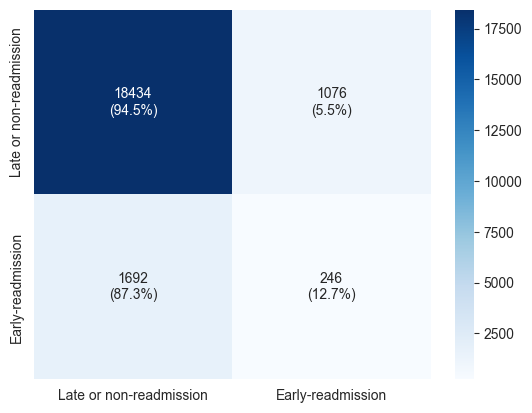

In [25]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [26]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-10, 1e-1, log=True)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        GaussianNB(**params)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [27]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 07:49:43,001] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [28]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-16 07:49:44,134] Trial 0 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 1.5767894702371863e-07}. Best is trial 0 with value: 0.5096378307965799.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:44,416] Trial 2 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 1.5154992642563622e-05}. Best is trial 0 with value: 0.5096378307965799.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.50868579 0.51365273 0.51309228 0.5095407  0.50374593]
Average score: 0.5097434860889061
Cross validation scores: [0.50872528 0.51387983 0.51256053 0.50957644 0.50395943]
Average score: 0.5097403008576568


[I 2025-01-16 07:49:44,623] Trial 1 finished with value: 0.5097434860889061 and parameters: {'var_smoothing': 0.011414609870509487}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:44,654] Trial 5 finished with value: 0.5097403008576568 and parameters: {'var_smoothing': 0.007105805378727018}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:44,710] Trial 6 finished with value: 0.5096330609122361 and parameters: {'var_smoothing': 0.0009754698731845283}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:44,744] Trial 4 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 4.59418429220676e-06}. Best is trial 1 with value: 0.5097434860889061.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5090289  0.51317466 0.51337108 0.50892365 0.50366702]
Average score: 0.5096330609122361
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:44,774] Trial 7 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 8.626047326775239e-07}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:44,803] Trial 3 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 2.3554453615681636e-10}. Best is trial 1 with value: 0.5097434860889061.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5090289  0.51310997 0.51337108 0.50892365 0.50415376]
Average score: 0.5097174706515226


[I 2025-01-16 07:49:45,205] Trial 8 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 3.0114912612768026e-08}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:45,216] Trial 9 finished with value: 0.5097174706515226 and parameters: {'var_smoothing': 0.0007217568516522776}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:45,785] Trial 11 finished with value: 0.5096330609122361 and parameters: {'var_smoothing': 0.0010752845655104838}. Best is trial 1 with value: 0.5097434860889061.


Cross validation scores: [0.5090289  0.51317466 0.51337108 0.50892365 0.50366702]
Average score: 0.5096330609122361


[I 2025-01-16 07:49:46,024] Trial 10 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 2.597975809752488e-09}. Best is trial 1 with value: 0.5097434860889061.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:46,193] Trial 13 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 7.118720002374202e-09}. Best is trial 1 with value: 0.5097434860889061.
[I 2025-01-16 07:49:46,359] Trial 15 finished with value: 0.5097931431314909 and parameters: {'var_smoothing': 0.005259938139863021}. Best is trial 15 with value: 0.5097931431314909.
[I 2025-01-16 07:49:46,419] Trial 12 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 2.013054111094366e-10}. Best is trial 15 with value: 0.5097931431314909.


Cross validation scores: [0.50821128 0.51356304 0.51354534 0.50975915 0.50388691]
Average score: 0.5097931431314909
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:46,469] Trial 14 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 1.9592487477460433e-10}. Best is trial 15 with value: 0.5097931431314909.
[I 2025-01-16 07:49:46,589] Trial 17 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 5.2098398376408476e-05}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:46,597] Trial 16 finished with value: 0.5142867503116977 and parameters: {'var_smoothing': 0.09015483769510708}. Best is trial 16 with value: 0.5142867503116977.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.51426546 0.51922135 0.51672836 0.51293028 0.5082883 ]
Average score: 0.5142867503116977


[I 2025-01-16 07:49:46,867] Trial 18 finished with value: 0.5139274836320696 and parameters: {'var_smoothing': 0.08718364196994285}. Best is trial 16 with value: 0.5142867503116977.


Cross validation scores: [0.51363378 0.51871328 0.51653773 0.51267373 0.50807891]
Average score: 0.5139274836320696


[I 2025-01-16 07:49:47,073] Trial 19 finished with value: 0.509994716203737 and parameters: {'var_smoothing': 0.014354162926160572}. Best is trial 16 with value: 0.5142867503116977.


Cross validation scores: [0.50889037 0.51398651 0.51341693 0.50935687 0.50432291]
Average score: 0.509994716203737
Cross validation scores: [0.50896448 0.5129806  0.51337108 0.50873105 0.50420617]
Average score: 0.5096506765618312


[I 2025-01-16 07:49:47,085] Trial 20 finished with value: 0.5096506765618312 and parameters: {'var_smoothing': 9.117374148373355e-05}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:47,586] Trial 21 finished with value: 0.5135965273830272 and parameters: {'var_smoothing': 0.07537367798519906}. Best is trial 16 with value: 0.5142867503116977.


Cross validation scores: [0.51345638 0.51806274 0.51731814 0.51200325 0.50714213]
Average score: 0.5135965273830272


[I 2025-01-16 07:49:47,807] Trial 22 finished with value: 0.5095761710343826 and parameters: {'var_smoothing': 0.00021004547636352226}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:47,917] Trial 23 finished with value: 0.5096635148923216 and parameters: {'var_smoothing': 0.00012718345999341224}. Best is trial 16 with value: 0.5142867503116977.


Cross validation scores: [0.50896448 0.5129806  0.51324097 0.50879524 0.50389956]
Average score: 0.5095761710343826
Cross validation scores: [0.50896448 0.5129806  0.51337108 0.50879524 0.50420617]
Average score: 0.5096635148923216
Cross validation scores: [0.51368051 0.5190365  0.51716625 0.5111786  0.50646754]
Average score: 0.5135058797938021
Cross validation scores: [0.51367068 0.51801056 0.51634441 0.51210896 0.50784275]
Average score: 0.5135954712447803


[I 2025-01-16 07:49:48,035] Trial 24 finished with value: 0.5135058797938021 and parameters: {'var_smoothing': 0.06707280780014793}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:48,126] Trial 25 finished with value: 0.5135954712447803 and parameters: {'var_smoothing': 0.08216537014357028}. Best is trial 16 with value: 0.5142867503116977.


Cross validation scores: [0.50886639 0.51371745 0.51322211 0.50998149 0.50387259]
Average score: 0.5099320075983461
Cross validation scores: [0.50946903 0.51386156 0.51361183 0.5096137  0.50395544]
Average score: 0.5101023124733027
Cross validation scores: [0.50880022 0.51323937 0.51351627 0.50912666 0.50344299]
Average score: 0.5096251023007817


[I 2025-01-16 07:49:48,378] Trial 26 finished with value: 0.5099320075983461 and parameters: {'var_smoothing': 0.011919291777878116}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:48,395] Trial 27 finished with value: 0.5096251023007817 and parameters: {'var_smoothing': 0.0030514891795819323}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:48,567] Trial 28 finished with value: 0.5101023124733027 and parameters: {'var_smoothing': 0.015354119285509194}. Best is trial 16 with value: 0.5142867503116977.
[I 2025-01-16 07:49:48,736] Trial 29 finished with value: 0.5143894886668221 and parameters: {'var_smoothing': 0.09536904465181965}. Best is trial 29 with value: 0.5143894886668221.


Cross validation scores: [0.51443601 0.51945559 0.51705041 0.51251641 0.50848901]
Average score: 0.5143894886668221


[I 2025-01-16 07:49:49,030] Trial 30 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 2.8043732021207593e-07}. Best is trial 29 with value: 0.5143894886668221.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.51047293 0.51601204 0.51448804 0.51068593 0.50343351]
Average score: 0.5110184888472351


[I 2025-01-16 07:49:49,186] Trial 31 finished with value: 0.5110184888472351 and parameters: {'var_smoothing': 0.03101556568934833}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:49,341] Trial 32 finished with value: 0.5107860830114213 and parameters: {'var_smoothing': 0.023116023017529765}. Best is trial 29 with value: 0.5143894886668221.


Cross validation scores: [0.5100458  0.5151707  0.51480663 0.51066586 0.50324141]
Average score: 0.5107860830114213
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:49,490] Trial 33 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 1.5573937007076135e-05}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:49,854] Trial 35 finished with value: 0.5096275915650694 and parameters: {'var_smoothing': 0.00038830811590867645}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:49,935] Trial 36 finished with value: 0.509637974739383 and parameters: {'var_smoothing': 0.0029676990556712175}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:49,946] Trial 34 finished with value: 0.5096479594220985 and parameters: {'var_smoothing': 0.0016520296284775015}. Best is trial 29 with value: 0.5143894886668221.


Cross validation scores: [0.50896448 0.51310997 0.51324097 0.50885944 0.5039631 ]
Average score: 0.5096275915650694
Cross validation scores: [0.5092222  0.51317466 0.51312603 0.50885944 0.50385746]
Average score: 0.5096479594220985
Cross validation scores: [0.50886459 0.51323937 0.51351627 0.50912666 0.50344299]
Average score: 0.509637974739383
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:50,163] Trial 37 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 3.2283575519629055e-06}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:50,299] Trial 38 finished with value: 0.5137980290278691 and parameters: {'var_smoothing': 0.08523939367933973}. Best is trial 29 with value: 0.5143894886668221.


Cross validation scores: [0.51351531 0.51853012 0.51653773 0.51222516 0.50818183]
Average score: 0.5137980290278691
Cross validation scores: [0.50867779 0.51744663 0.51597619 0.51102394 0.50467639]
Average score: 0.5115601893023052


[I 2025-01-16 07:49:50,470] Trial 39 finished with value: 0.5115601893023052 and parameters: {'var_smoothing': 0.03827177253592794}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:50,607] Trial 40 finished with value: 0.5098477257752334 and parameters: {'var_smoothing': 0.006387982602989931}. Best is trial 29 with value: 0.5143894886668221.
[I 2025-01-16 07:49:50,718] Trial 41 finished with value: 0.5122533921141705 and parameters: {'var_smoothing': 0.04800131035915047}. Best is trial 29 with value: 0.5143894886668221.


Cross validation scores: [0.50840397 0.51375021 0.5134293  0.50975915 0.503896  ]
Average score: 0.5098477257752334
Cross validation scores: [0.51060652 0.51764611 0.51620516 0.5113678  0.50544136]
Average score: 0.5122533921141705


[I 2025-01-16 07:49:51,037] Trial 42 finished with value: 0.5147245746186293 and parameters: {'var_smoothing': 0.09712155728272243}. Best is trial 42 with value: 0.5147245746186293.


Cross validation scores: [0.5142958  0.5199117  0.51731042 0.51290079 0.50920417]
Average score: 0.5147245746186293


[I 2025-01-16 07:49:51,233] Trial 43 finished with value: 0.509599484136007 and parameters: {'var_smoothing': 0.0028342271378228308}. Best is trial 42 with value: 0.5147245746186293.


Cross validation scores: [0.50880022 0.51317466 0.51351627 0.50912666 0.5033796 ]
Average score: 0.509599484136007
Cross validation scores: [0.50898249 0.51349828 0.51250849 0.50939353 0.50371452]
Average score: 0.5096194614958242


[I 2025-01-16 07:49:51,421] Trial 44 finished with value: 0.5096194614958242 and parameters: {'var_smoothing': 0.008030879739392824}. Best is trial 42 with value: 0.5147245746186293.
[I 2025-01-16 07:49:51,537] Trial 45 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 1.7250788629704298e-05}. Best is trial 42 with value: 0.5147245746186293.
[I 2025-01-16 07:49:51,659] Trial 46 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 7.644577648862106e-07}. Best is trial 42 with value: 0.5147245746186293.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:51,807] Trial 47 finished with value: 0.5096792053246126 and parameters: {'var_smoothing': 0.0006629232599807551}. Best is trial 42 with value: 0.5147245746186293.


Cross validation scores: [0.5090289  0.51310997 0.51337108 0.50885944 0.50402664]
Average score: 0.5096792053246126
Cross validation scores: [0.5100458  0.5151707  0.51480663 0.51066586 0.50330442]
Average score: 0.51079868402325
Cross validation scores: [0.50919648 0.51771082 0.51623712 0.51128584 0.50484607]
Average score: 0.5118552651448489


[I 2025-01-16 07:49:51,957] Trial 48 finished with value: 0.51079868402325 and parameters: {'var_smoothing': 0.023150914567107297}. Best is trial 42 with value: 0.5147245746186293.
[I 2025-01-16 07:49:51,985] Trial 49 finished with value: 0.5118552651448489 and parameters: {'var_smoothing': 0.04174525198156717}. Best is trial 42 with value: 0.5147245746186293.
[I 2025-01-16 07:49:52,227] Trial 50 finished with value: 0.514850441746044 and parameters: {'var_smoothing': 0.09767786382411806}. Best is trial 50 with value: 0.514850441746044.


Cross validation scores: [0.51442425 0.52004212 0.51763567 0.5132214  0.50892878]
Average score: 0.514850441746044
Cross validation scores: [0.50889037 0.51405125 0.51348189 0.50935687 0.50432291]
Average score: 0.510020655600206


[I 2025-01-16 07:49:52,398] Trial 51 finished with value: 0.510020655600206 and parameters: {'var_smoothing': 0.014433565360827728}. Best is trial 50 with value: 0.514850441746044.
[I 2025-01-16 07:49:52,646] Trial 52 finished with value: 0.5142677182015158 and parameters: {'var_smoothing': 0.09284928320892938}. Best is trial 50 with value: 0.514850441746044.
[I 2025-01-16 07:49:52,801] Trial 53 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 5.570859059788765e-10}. Best is trial 50 with value: 0.514850441746044.


Cross validation scores: [0.51451162 0.51953406 0.51692322 0.51252431 0.50784538]
Average score: 0.5142677182015158
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799


[I 2025-01-16 07:49:52,957] Trial 54 finished with value: 0.5098477257752334 and parameters: {'var_smoothing': 0.0064352165424875945}. Best is trial 50 with value: 0.514850441746044.


Cross validation scores: [0.50840397 0.51375021 0.5134293  0.50975915 0.503896  ]
Average score: 0.5098477257752334


[I 2025-01-16 07:49:53,142] Trial 55 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 2.045273772511407e-08}. Best is trial 50 with value: 0.514850441746044.


Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.5092222  0.51317466 0.51337108 0.50892365 0.50373049]
Average score: 0.5096844153513165
Cross validation scores: [0.51039328 0.51536529 0.51420935 0.51048676 0.50305783]
Average score: 0.5107025028426466


[I 2025-01-16 07:49:53,348] Trial 56 finished with value: 0.5096844153513165 and parameters: {'var_smoothing': 0.0012724433371504016}. Best is trial 50 with value: 0.514850441746044.
[I 2025-01-16 07:49:53,366] Trial 57 finished with value: 0.5107025028426466 and parameters: {'var_smoothing': 0.02773725072454743}. Best is trial 50 with value: 0.514850441746044.
[I 2025-01-16 07:49:53,580] Trial 58 finished with value: 0.5139585557188109 and parameters: {'var_smoothing': 0.08655538452659649}. Best is trial 50 with value: 0.514850441746044.


Cross validation scores: [0.5138362  0.51879018 0.51666761 0.51254552 0.50795326]
Average score: 0.5139585557188109
Cross validation scores: [0.50951767 0.51797343 0.51599364 0.51135835 0.50522359]
Average score: 0.5120133346583661


[I 2025-01-16 07:49:53,673] Trial 59 finished with value: 0.5120133346583661 and parameters: {'var_smoothing': 0.04394105496057386}. Best is trial 50 with value: 0.514850441746044.
[I 2025-01-16 07:49:53,921] Trial 60 finished with value: 0.5101620315086428 and parameters: {'var_smoothing': 0.014945033024271132}. Best is trial 50 with value: 0.514850441746044.


Cross validation scores: [0.50908318 0.514116   0.51361183 0.50954948 0.50444967]
Average score: 0.5101620315086428
Cross validation scores: [0.51414271 0.5205643  0.51730356 0.51334119 0.50921885]
Average score: 0.5149141236688743


[I 2025-01-16 07:49:54,061] Trial 61 finished with value: 0.5149141236688743 and parameters: {'var_smoothing': 0.09953977254205612}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:54,218] Trial 62 finished with value: 0.5096181751534765 and parameters: {'var_smoothing': 0.0034954788976037663}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.50831339 0.51323937 0.51377662 0.50925512 0.50350638]
Average score: 0.5096181751534765


[I 2025-01-16 07:49:54,438] Trial 63 finished with value: 0.5096334765075722 and parameters: {'var_smoothing': 0.010156866734387674}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.50836466 0.51338823 0.51320945 0.50940307 0.50380197]
Average score: 0.5096334765075722


[I 2025-01-16 07:49:54,751] Trial 65 finished with value: 0.5108841876290345 and parameters: {'var_smoothing': 0.02538186733435255}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:54,771] Trial 64 finished with value: 0.5106716865931265 and parameters: {'var_smoothing': 0.021538801857177922}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.51044081 0.51542752 0.51457916 0.51066586 0.50330759]
Average score: 0.5108841876290345
Cross validation scores: [0.50971486 0.51509654 0.514351   0.51045761 0.50373842]
Average score: 0.5106716865931265


[I 2025-01-16 07:49:55,034] Trial 66 finished with value: 0.5126766245342123 and parameters: {'var_smoothing': 0.05434373787015722}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:55,042] Trial 67 finished with value: 0.5097600981844856 and parameters: {'var_smoothing': 0.006177461740057313}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.51150429 0.51921104 0.51642176 0.51073366 0.50551237]
Average score: 0.5126766245342123
Cross validation scores: [0.5082755  0.51375021 0.51349432 0.50944788 0.50383257]
Average score: 0.5097600981844856
Cross validation scores: [0.51432971 0.51928645 0.51666343 0.51299444 0.50841399]
Average score: 0.5143376053807747


[I 2025-01-16 07:49:55,178] Trial 68 finished with value: 0.5143376053807747 and parameters: {'var_smoothing': 0.09036851296068017}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.5138362  0.51879018 0.51666761 0.51254552 0.50795326]
Average score: 0.5139585557188109
Cross validation scores: [0.51436002 0.5199117  0.51744048 0.51296489 0.50920417]
Average score: 0.5147762518937865


[I 2025-01-16 07:49:55,393] Trial 69 finished with value: 0.5139585557188109 and parameters: {'var_smoothing': 0.08662903411517446}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:55,418] Trial 70 finished with value: 0.5147762518937865 and parameters: {'var_smoothing': 0.09720978535183193}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:55,592] Trial 71 finished with value: 0.5120252153098956 and parameters: {'var_smoothing': 0.044345089736223885}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.50951767 0.51810394 0.51592846 0.51135835 0.50521766]
Average score: 0.5120252153098956


[I 2025-01-16 07:49:55,900] Trial 72 finished with value: 0.5099189868649533 and parameters: {'var_smoothing': 0.01193779994123723}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:56,021] Trial 73 finished with value: 0.5099126180899429 and parameters: {'var_smoothing': 0.013218735602687449}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.50886639 0.51378218 0.51309228 0.50998149 0.50387259]
Average score: 0.5099189868649533
Cross validation scores: [0.50863341 0.51397642 0.51309228 0.50998149 0.50387948]
Average score: 0.5099126180899429


[I 2025-01-16 07:49:56,282] Trial 75 finished with value: 0.5123031738023199 and parameters: {'var_smoothing': 0.04775670467490203}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:56,398] Trial 74 finished with value: 0.512304889632549 and parameters: {'var_smoothing': 0.0485776638270514}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.5104144  0.51758098 0.51671132 0.5113678  0.50544136]
Average score: 0.5123031738023199
Cross validation scores: [0.51060652 0.51771126 0.51627036 0.51143205 0.50550426]
Average score: 0.512304889632549


[I 2025-01-16 07:49:56,574] Trial 76 finished with value: 0.514340260194775 and parameters: {'var_smoothing': 0.0938244530930049}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.51430753 0.51966437 0.51692048 0.51252431 0.50828462]
Average score: 0.514340260194775


[I 2025-01-16 07:49:56,825] Trial 78 finished with value: 0.5108328251640678 and parameters: {'var_smoothing': 0.025564216746957705}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:56,841] Trial 77 finished with value: 0.5148866052172297 and parameters: {'var_smoothing': 0.09797373786660638}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.51044081 0.5151707  0.51457916 0.51066586 0.50330759]
Average score: 0.5108328251640678
Cross validation scores: [0.51421945 0.52023785 0.51763567 0.51328555 0.50905452]
Average score: 0.5148866052172297
Cross validation scores: [0.50832674 0.51343354 0.51341527 0.50938362 0.50376004]
Average score: 0.5096638411223251


[I 2025-01-16 07:49:56,959] Trial 79 finished with value: 0.5096638411223251 and parameters: {'var_smoothing': 0.004160002014767228}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:57,193] Trial 80 finished with value: 0.5106716865931265 and parameters: {'var_smoothing': 0.021572170717859863}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:57,283] Trial 81 finished with value: 0.5133139640823712 and parameters: {'var_smoothing': 0.05906742337951969}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.50971486 0.51509654 0.514351   0.51045761 0.50373842]
Average score: 0.5106716865931265
Cross validation scores: [0.5130454  0.51959621 0.51649905 0.51124754 0.50618163]
Average score: 0.5133139640823712


[I 2025-01-16 07:49:57,536] Trial 82 finished with value: 0.5109852276017414 and parameters: {'var_smoothing': 0.029096234401301352}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:57,673] Trial 83 finished with value: 0.5148173207286134 and parameters: {'var_smoothing': 0.09839178399649152}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.51090001 0.51594411 0.51434888 0.51048676 0.50324638]
Average score: 0.5109852276017414
Cross validation scores: [0.51414271 0.52036839 0.51737221 0.51314878 0.50905452]
Average score: 0.5148173207286134
Cross validation scores: [0.50842887 0.51325274 0.51276786 0.50939353 0.50347761]
Average score: 0.5094641231649806


[I 2025-01-16 07:49:57,827] Trial 84 finished with value: 0.5094641231649806 and parameters: {'var_smoothing': 0.008848147844273591}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:58,172] Trial 86 finished with value: 0.5130589672672675 and parameters: {'var_smoothing': 0.0578829080976668}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:58,190] Trial 85 finished with value: 0.5128286461719748 and parameters: {'var_smoothing': 0.05657682387257781}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.5122082  0.51966451 0.51630357 0.51086282 0.50625574]
Average score: 0.5130589672672675
Cross validation scores: [0.51201686 0.51940282 0.51636283 0.51067058 0.50569014]
Average score: 0.5128286461719748
Cross validation scores: [0.5092222  0.51317466 0.51312603 0.50885944 0.50385746]
Average score: 0.5096479594220985


[I 2025-01-16 07:49:58,297] Trial 87 finished with value: 0.5096479594220985 and parameters: {'var_smoothing': 0.0015847432860074328}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:58,508] Trial 88 finished with value: 0.5110625150731221 and parameters: {'var_smoothing': 0.033837404291249984}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.50998548 0.51614456 0.51493402 0.51056896 0.50367956]
Average score: 0.5110625150731221
Cross validation scores: [0.50900822 0.51547347 0.51415587 0.5100635  0.503858  ]
Average score: 0.5105118123189388


[I 2025-01-16 07:49:58,640] Trial 89 finished with value: 0.5105118123189388 and parameters: {'var_smoothing': 0.01971827640116462}. Best is trial 61 with value: 0.5149141236688743.
[I 2025-01-16 07:49:58,790] Trial 90 finished with value: 0.5135828999952345 and parameters: {'var_smoothing': 0.08201910029151618}. Best is trial 61 with value: 0.5149141236688743.


Cross validation scores: [0.51367068 0.51801056 0.51634441 0.51210896 0.50777989]
Average score: 0.5135828999952345
Cross validation scores: [0.50998548 0.51620956 0.51486896 0.51056896 0.50367956]
Average score: 0.5110625054213306
Cross validation scores: [0.51393733 0.52069497 0.51730356 0.51346952 0.50934466]
Average score: 0.5149500088133655


[I 2025-01-16 07:49:58,945] Trial 91 finished with value: 0.5110625054213306 and parameters: {'var_smoothing': 0.033910776688527}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:58,965] Trial 92 finished with value: 0.5149500088133655 and parameters: {'var_smoothing': 0.09983651359132431}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:59,374] Trial 93 finished with value: 0.5149243589086757 and parameters: {'var_smoothing': 0.09969812816692943}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:59,451] Trial 94 finished with value: 0.5096378307965799 and parameters: {'var_smoothing': 6.680524122772577e-08}. Best is trial 92 with value: 0.5149500088133655.


Cross validation scores: [0.51393733 0.52062963 0.51730356 0.51346952 0.50928175]
Average score: 0.5149243589086757
Cross validation scores: [0.5090289  0.5129806  0.51330602 0.50873105 0.50414258]
Average score: 0.5096378307965799
Cross validation scores: [0.50885031 0.51317466 0.51325608 0.50930908 0.50356025]
Average score: 0.5096300758395016


[I 2025-01-16 07:49:59,538] Trial 95 finished with value: 0.5096300758395016 and parameters: {'var_smoothing': 0.0023998628817135854}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:59,610] Trial 96 finished with value: 0.5102015754525426 and parameters: {'var_smoothing': 0.01677360550330013}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:59,674] Trial 97 finished with value: 0.5115615767138926 and parameters: {'var_smoothing': 0.0379677126185642}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:59,743] Trial 99 finished with value: 0.5134568868868088 and parameters: {'var_smoothing': 0.06678646915833614}. Best is trial 92 with value: 0.5149500088133655.
[I 2025-01-16 07:49:59,743] Trial 98 finished with value: 0.5144665269613186 and parameters: {'var_smoothing': 0.09589388282573509}. Best is trial 92 with value: 0.5149500088133655.


Cross validation scores: [0.50941604 0.51463435 0.51362406 0.50967793 0.5036555 ]
Average score: 0.5102015754525426
Cross validation scores: [0.50867779 0.51757707 0.51597619 0.51095966 0.50461717]
Average score: 0.5115615767138926
Cross validation scores: [0.51443601 0.51958585 0.51705041 0.51270855 0.50855181]
Average score: 0.5144665269613186
Cross validation scores: [0.51368051 0.51930359 0.51703579 0.51092255 0.506342  ]
Average score: 0.5134568868868088


In [29]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 92
Best Parameters: {'var_smoothing': 0.09983651359132431}
Best Value: 0.5149500088133655


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [30]:
optuna.visualization.plot_optimization_history(study)

In [31]:
optuna.visualization.plot_slice(study)

In [32]:
optuna.visualization.plot_param_importances(study)

In [33]:
optuna.visualization.plot_parallel_coordinate(study)

In [34]:
optuna.visualization.plot_contour(study)

In [35]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [36]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    GaussianNB(**best_params)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('gaussiannb', GaussianNB(var_smoothing=0.09983651359132431))])

In [37]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [38]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.7097212508742132
Test accuracy:  0.7088306602014174


In [39]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.74      0.82     19510
      Early-readmission       0.13      0.41      0.20      1938

               accuracy                           0.71     21448
              macro avg       0.53      0.57      0.51     21448
           weighted avg       0.85      0.71      0.77     21448



In [40]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

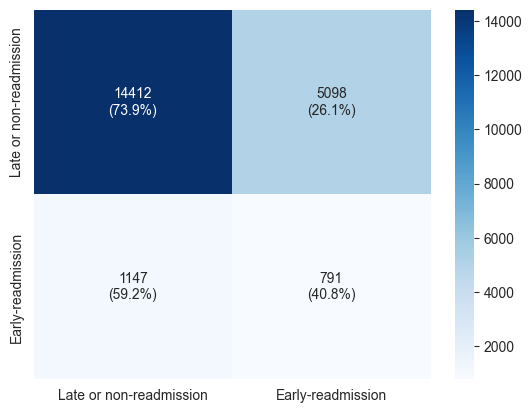

In [41]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [42]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-10, 1e-1, log=True)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        GaussianNB(**params)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [43]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 07:50:01,048] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [44]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-16 07:50:03,897] Trial 2 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 3.0026550102169705e-10}. Best is trial 2 with value: 0.5104862554841415.
[I 2025-01-16 07:50:03,992] Trial 5 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 1.9904686696934445e-09}. Best is trial 2 with value: 0.5104862554841415.
[I 2025-01-16 07:50:04,025] Trial 0 finished with value: 0.5104178802943949 and parameters: {'var_smoothing': 0.0006684819921670668}. Best is trial 2 with value: 0.5104862554841415.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50859673 0.5143581  0.51500204 0.5105781  0.50355443]
Average score: 0.5104178802943949
Cross validation scores: [0.50886604 0.5151649  0.5185271  0.51252571 0.50501596]
Average score: 0.5120199426833619


[I 2025-01-16 07:50:04,114] Trial 3 finished with value: 0.5120199426833619 and parameters: {'var_smoothing': 0.027146313042630987}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:04,297] Trial 1 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 4.5754501356160903e-07}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:04,304] Trial 6 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 5.955568998031374e-08}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50866101 0.51417215 0.51500204 0.51032897 0.5036175 ]
Average score: 0.5103563332300305


[I 2025-01-16 07:50:04,325] Trial 7 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 4.588677191479776e-08}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:04,412] Trial 4 finished with value: 0.5103563332300305 and parameters: {'var_smoothing': 0.0008564177587962466}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:06,646] Trial 8 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 4.234165621834064e-09}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:06,930] Trial 9 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 9.686366613976284e-10}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:07,024] Trial 10 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 7.288045959427393e-08}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:07,048] Trial 11 finished with value: 0.5104992483402838 and parameters: {'var_smoothing': 9.531677590066401e-06}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50876343 0.51442306 0.51499043 0.5105781  0.50374123]
Average score: 0.5104992483402838
Cross validation scores: [0.50859673 0.51423708 0.51519754 0.51001548 0.5029299 ]
Average score: 0.5101953452414627


[I 2025-01-16 07:50:07,134] Trial 12 finished with value: 0.5101953452414627 and parameters: {'var_smoothing': 0.0014475557573672172}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:07,306] Trial 13 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 2.7480051591479623e-07}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:07,310] Trial 14 finished with value: 0.5109699729707042 and parameters: {'var_smoothing': 0.008555669097918292}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50954468 0.51498313 0.51663382 0.51101333 0.50267491]
Average score: 0.5109699729707042


[I 2025-01-16 07:50:07,445] Trial 15 finished with value: 0.5103343946712456 and parameters: {'var_smoothing': 0.003149325839623121}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50881429 0.51449686 0.51558879 0.50996605 0.50280598]
Average score: 0.5103343946712456


[I 2025-01-16 07:50:09,562] Trial 16 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 1.5291366313044883e-09}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:09,688] Trial 17 finished with value: 0.5104992483402838 and parameters: {'var_smoothing': 3.8954601902763186e-05}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.50876343 0.51442306 0.51499043 0.5105781  0.50374123]
Average score: 0.5104992483402838


[I 2025-01-16 07:50:09,967] Trial 18 finished with value: 0.5104992483402838 and parameters: {'var_smoothing': 2.154307709418846e-05}. Best is trial 3 with value: 0.5120199426833619.
[I 2025-01-16 07:50:10,064] Trial 19 finished with value: 0.5104992483402838 and parameters: {'var_smoothing': 2.667788059084392e-05}. Best is trial 3 with value: 0.5120199426833619.


Cross validation scores: [0.50876343 0.51442306 0.51499043 0.5105781  0.50374123]
Average score: 0.5104992483402838
Cross validation scores: [0.50876343 0.51442306 0.51499043 0.5105781  0.50374123]
Average score: 0.5104992483402838
Cross validation scores: [0.5115788  0.51683066 0.51993498 0.51427987 0.50730246]
Average score: 0.5139853540175806


[I 2025-01-16 07:50:10,181] Trial 20 finished with value: 0.5139853540175806 and parameters: {'var_smoothing': 0.06955691866771847}. Best is trial 20 with value: 0.5139853540175806.
[I 2025-01-16 07:50:10,338] Trial 22 finished with value: 0.5151738157827994 and parameters: {'var_smoothing': 0.09861344892846174}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:10,453] Trial 21 finished with value: 0.5149541058748752 and parameters: {'var_smoothing': 0.09504317687893793}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51477981 0.51736214 0.51916054 0.51544099 0.5091256 ]
Average score: 0.5151738157827994
Cross validation scores: [0.51426546 0.51690894 0.5194342  0.51526025 0.50890169]
Average score: 0.5149541058748752
Cross validation scores: [0.50924482 0.51441233 0.51664478 0.51139937 0.50210303]
Average score: 0.5107608657257672


[I 2025-01-16 07:50:10,562] Trial 23 finished with value: 0.5107608657257672 and parameters: {'var_smoothing': 0.009766729874373046}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:12,369] Trial 24 finished with value: 0.5104263959541238 and parameters: {'var_smoothing': 0.0001530943722279588}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50864808 0.51442306 0.51474151 0.5105781  0.50374123]
Average score: 0.5104263959541238
Cross validation scores: [0.50915546 0.51455419 0.51743006 0.51198435 0.50253398]
Average score: 0.5111316058432853


[I 2025-01-16 07:50:12,578] Trial 25 finished with value: 0.5111316058432853 and parameters: {'var_smoothing': 0.013552226717523907}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:12,850] Trial 26 finished with value: 0.5104394195951676 and parameters: {'var_smoothing': 0.00019135936694310516}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50864808 0.51442306 0.51480663 0.5105781  0.50374123]
Average score: 0.5104394195951676


[I 2025-01-16 07:50:13,055] Trial 27 finished with value: 0.5112308673596401 and parameters: {'var_smoothing': 0.016884320538307882}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:13,154] Trial 28 finished with value: 0.5120462617701913 and parameters: {'var_smoothing': 0.029696595158150044}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50893233 0.51424553 0.51675033 0.51237115 0.503855  ]
Average score: 0.5112308673596401
Cross validation scores: [0.50950868 0.51465673 0.51866677 0.5122721  0.50512703]
Average score: 0.5120462617701913


[I 2025-01-16 07:50:13,688] Trial 29 finished with value: 0.5146147589281974 and parameters: {'var_smoothing': 0.08921105728380381}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:13,733] Trial 30 finished with value: 0.5139142652315234 and parameters: {'var_smoothing': 0.06810095418746956}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:13,769] Trial 31 finished with value: 0.5104406601082692 and parameters: {'var_smoothing': 0.0037765455271285444}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51338702 0.51667177 0.51984232 0.51475741 0.50841528]
Average score: 0.5146147589281974
Cross validation scores: [0.50876188 0.51469181 0.51578454 0.51015872 0.50280635]
Average score: 0.5104406601082692
Cross validation scores: [0.51171313 0.51663611 0.51973839 0.51382949 0.50765421]
Average score: 0.5139142652315234


[I 2025-01-16 07:50:15,406] Trial 32 finished with value: 0.5104392749436184 and parameters: {'var_smoothing': 0.00034186868729002855}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50877668 0.5143581  0.51480663 0.51051374 0.50374123]
Average score: 0.5104392749436184


[I 2025-01-16 07:50:16,117] Trial 34 finished with value: 0.5101989489320233 and parameters: {'var_smoothing': 0.0019511272209995028}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:16,120] Trial 33 finished with value: 0.5144123758316351 and parameters: {'var_smoothing': 0.08669953063677363}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50860932 0.51430201 0.51526272 0.51001548 0.50280522]
Average score: 0.5101989489320233
Cross validation scores: [0.51313058 0.51648785 0.51945446 0.51458684 0.50840214]
Average score: 0.5144123758316351
Cross validation scores: [0.50877668 0.5143581  0.51500204 0.5105781  0.50374123]
Average score: 0.510491228265871


[I 2025-01-16 07:50:16,247] Trial 35 finished with value: 0.510491228265871 and parameters: {'var_smoothing': 0.0005178299207547173}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:16,522] Trial 36 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 1.747856607219214e-06}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:17,089] Trial 37 finished with value: 0.5133401362033557 and parameters: {'var_smoothing': 0.06300398504227465}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:17,096] Trial 39 finished with value: 0.5119705765683481 and parameters: {'var_smoothing': 0.028528790374029868}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:17,181] Trial 38 finished with value: 0.5147159088276849 and parameters: {'var_smoothing': 0.09351421023143958}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51115433 0.51606263 0.51882258 0.51372454 0.50693661]
Average score: 0.5133401362033557
Cross validation scores: [0.50899719 0.51471944 0.51853556 0.51227031 0.50533039]
Average score: 0.5119705765683481
Cross validation scores: [0.51368764 0.51684424 0.51943988 0.51520782 0.50839997]
Average score: 0.5147159088276849


[I 2025-01-16 07:50:18,620] Trial 40 finished with value: 0.5105963751841263 and parameters: {'var_smoothing': 0.004433797916009578}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.5090189  0.51495186 0.51598039 0.51028722 0.50274351]
Average score: 0.5105963751841263


[I 2025-01-16 07:50:19,073] Trial 41 finished with value: 0.5118806138988105 and parameters: {'var_smoothing': 0.027981213759429528}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50861394 0.51503829 0.51833882 0.51227031 0.50514171]
Average score: 0.5118806138988105


[I 2025-01-16 07:50:19,384] Trial 42 finished with value: 0.5103451196177896 and parameters: {'var_smoothing': 0.001085692164123448}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50859673 0.51423708 0.51513236 0.51032897 0.50343045]
Average score: 0.5103451196177896
Cross validation scores: [0.50934038 0.51451342 0.51598039 0.51022976 0.50268031]
Average score: 0.5105488513345928


[I 2025-01-16 07:50:19,548] Trial 43 finished with value: 0.5105488513345928 and parameters: {'var_smoothing': 0.005529199308895242}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:19,663] Trial 44 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 2.637836304085891e-10}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:20,278] Trial 45 finished with value: 0.5125730736408795 and parameters: {'var_smoothing': 0.03404087266375301}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:20,355] Trial 46 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 1.3534062412779312e-08}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50983734 0.51537099 0.51836909 0.51343193 0.50585602]
Average score: 0.5125730736408795
Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:20,521] Trial 47 finished with value: 0.5149368655517627 and parameters: {'var_smoothing': 0.09529806520804471}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51426546 0.51697365 0.5194342  0.51532463 0.5086864 ]
Average score: 0.5149368655517627


[I 2025-01-16 07:50:21,892] Trial 48 finished with value: 0.5110441840249181 and parameters: {'var_smoothing': 0.013605012038606153}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50890774 0.51430035 0.51743006 0.51204879 0.50253398]
Average score: 0.5110441840249181


[I 2025-01-16 07:50:22,528] Trial 49 finished with value: 0.5142329362622332 and parameters: {'var_smoothing': 0.07523298849306097}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51221159 0.51661153 0.51986551 0.51452278 0.50795326]
Average score: 0.5142329362622332


[I 2025-01-16 07:50:22,795] Trial 50 finished with value: 0.5150443419086503 and parameters: {'var_smoothing': 0.09724982608117116}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:22,812] Trial 51 finished with value: 0.5101401647959416 and parameters: {'var_smoothing': 0.002447910951076737}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51477981 0.51683278 0.51936281 0.51518349 0.50906282]
Average score: 0.5150443419086503
Cross validation scores: [0.50855731 0.51411578 0.51532792 0.5098946  0.50280522]
Average score: 0.5101401647959416


[I 2025-01-16 07:50:22,988] Trial 52 finished with value: 0.5108526069862989 and parameters: {'var_smoothing': 0.007835544894043617}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50948035 0.51472328 0.51637233 0.51088472 0.50280235]
Average score: 0.5108526069862989


[I 2025-01-16 07:50:23,415] Trial 53 finished with value: 0.5127650142429211 and parameters: {'var_smoothing': 0.035748696112800925}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:23,417] Trial 54 finished with value: 0.511018666204371 and parameters: {'var_smoothing': 0.013721232331604508}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50890774 0.51430035 0.51743006 0.51211324 0.50234194]
Average score: 0.511018666204371
Cross validation scores: [0.51015725 0.51517846 0.51882797 0.51317594 0.50648545]
Average score: 0.5127650142429211


[I 2025-01-16 07:50:23,915] Trial 55 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 1.680851043334469e-06}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:24,985] Trial 56 finished with value: 0.5104263959541238 and parameters: {'var_smoothing': 0.00010551038854837931}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50864808 0.51442306 0.51474151 0.5105781  0.50374123]
Average score: 0.5104263959541238


[I 2025-01-16 07:50:25,536] Trial 57 finished with value: 0.5103322670919466 and parameters: {'var_smoothing': 0.0011882374929785757}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50853247 0.51423708 0.51513236 0.51032897 0.50343045]
Average score: 0.5103322670919466


[I 2025-01-16 07:50:25,789] Trial 58 finished with value: 0.5143383800182968 and parameters: {'var_smoothing': 0.08358045606772385}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:25,910] Trial 59 finished with value: 0.5150362745621296 and parameters: {'var_smoothing': 0.09647055450443798}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51288355 0.51650678 0.51978923 0.51421163 0.5083007 ]
Average score: 0.5143383800182968
Cross validation scores: [0.51471547 0.51697365 0.5194342  0.51518349 0.50887456]
Average score: 0.5150362745621296


[I 2025-01-16 07:50:26,063] Trial 60 finished with value: 0.5126332569211296 and parameters: {'var_smoothing': 0.03906879658567185}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50996763 0.51543794 0.51909694 0.5130475  0.50561628]
Average score: 0.5126332569211296


[I 2025-01-16 07:50:26,704] Trial 62 finished with value: 0.5114130667631894 and parameters: {'var_smoothing': 0.01854834062192988}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50912463 0.51431471 0.5172734  0.51256467 0.50378792]
Average score: 0.5114130667631894
Cross validation scores: [0.50893233 0.51418519 0.51720798 0.51256467 0.5038507 ]
Average score: 0.5113481768680648


[I 2025-01-16 07:50:26,843] Trial 61 finished with value: 0.5113481768680648 and parameters: {'var_smoothing': 0.018269691382834838}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:27,290] Trial 63 finished with value: 0.5108123963373984 and parameters: {'var_smoothing': 0.007404692329665245}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50941604 0.51465834 0.51637233 0.51093687 0.5026784 ]
Average score: 0.5108123963373984


[I 2025-01-16 07:50:28,248] Trial 64 finished with value: 0.512696936464031 and parameters: {'var_smoothing': 0.03993121228299078}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51022342 0.51556755 0.51897188 0.51330526 0.50541657]
Average score: 0.512696936464031


[I 2025-01-16 07:50:28,658] Trial 65 finished with value: 0.515070408573855 and parameters: {'var_smoothing': 0.0980835727889965}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51477981 0.51716785 0.5190953  0.51518349 0.5091256 ]
Average score: 0.515070408573855


[I 2025-01-16 07:50:29,068] Trial 66 finished with value: 0.5104150381885748 and parameters: {'var_smoothing': 0.0037448263356040954}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50876188 0.51469181 0.51571928 0.51015872 0.5027435 ]
Average score: 0.5104150381885748


[I 2025-01-16 07:50:29,288] Trial 67 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 2.138962859535324e-07}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:29,437] Trial 68 finished with value: 0.5129922115687954 and parameters: {'var_smoothing': 0.04855672070580403}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.51021474 0.51497655 0.51971858 0.51349256 0.50655864]
Average score: 0.5129922115687954


[I 2025-01-16 07:50:29,648] Trial 69 finished with value: 0.5151137104912366 and parameters: {'var_smoothing': 0.09692601579334525}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51477981 0.5171031  0.51956485 0.51518349 0.50893731]
Average score: 0.5151137104912366
Cross validation scores: [0.50990184 0.51463869 0.51792814 0.51263835 0.50485147]
Average score: 0.5119916984675159


[I 2025-01-16 07:50:29,826] Trial 70 finished with value: 0.5119916984675159 and parameters: {'var_smoothing': 0.02170857687780107}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:30,156] Trial 71 finished with value: 0.5109073537938711 and parameters: {'var_smoothing': 0.010999631032941787}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50938362 0.51423    0.5169718  0.51159789 0.50235346]
Average score: 0.5109073537938711


[I 2025-01-16 07:50:31,384] Trial 72 finished with value: 0.5127192884213214 and parameters: {'var_smoothing': 0.04217106192816099}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51028685 0.51524238 0.51950264 0.5125951  0.50596947]
Average score: 0.5127192884213214


[I 2025-01-16 07:50:32,114] Trial 73 finished with value: 0.5150648516105717 and parameters: {'var_smoothing': 0.09612539967355134}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51465115 0.51697365 0.5194342  0.51545343 0.50881183]
Average score: 0.5150648516105717


[I 2025-01-16 07:50:32,680] Trial 74 finished with value: 0.5120056000616839 and parameters: {'var_smoothing': 0.022172361800980398}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50978035 0.51476835 0.51792814 0.51257385 0.50497731]
Average score: 0.5120056000616839


[I 2025-01-16 07:50:32,983] Trial 75 finished with value: 0.5106121569787027 and parameters: {'var_smoothing': 0.005763524400443089}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.5094047  0.51457836 0.5159151  0.51060862 0.50255401]
Average score: 0.5106121569787027
Cross validation scores: [0.51136843 0.5152256  0.51927471 0.51303035 0.50729912]
Average score: 0.5132396403938969


[I 2025-01-16 07:50:33,183] Trial 77 finished with value: 0.5132396403938969 and parameters: {'var_smoothing': 0.05402332689037012}. Best is trial 22 with value: 0.5151738157827994.
[I 2025-01-16 07:50:33,309] Trial 76 finished with value: 0.5107608657257672 and parameters: {'var_smoothing': 0.009751555159827341}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.50924482 0.51441233 0.51664478 0.51139937 0.50210303]
Average score: 0.5107608657257672


[I 2025-01-16 07:50:33,721] Trial 78 finished with value: 0.5150984066385649 and parameters: {'var_smoothing': 0.09758680372330342}. Best is trial 22 with value: 0.5151738157827994.


Cross validation scores: [0.51477981 0.5171031  0.51936281 0.51518349 0.50906282]
Average score: 0.5150984066385649


[I 2025-01-16 07:50:34,087] Trial 79 finished with value: 0.5152577605814829 and parameters: {'var_smoothing': 0.09943306291772484}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51484415 0.51742693 0.51875529 0.51563423 0.5096282 ]
Average score: 0.5152577605814829


[I 2025-01-16 07:50:35,160] Trial 80 finished with value: 0.5131773481320948 and parameters: {'var_smoothing': 0.05260381012940776}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51111232 0.51503173 0.51914369 0.51303386 0.50756514]
Average score: 0.5131773481320948


[I 2025-01-16 07:50:35,784] Trial 81 finished with value: 0.5120413209534092 and parameters: {'var_smoothing': 0.024942319514928493}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50967056 0.51490196 0.51807665 0.5121394  0.50541804]
Average score: 0.5120413209534092


[I 2025-01-16 07:50:36,261] Trial 82 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 7.665176710478947e-06}. Best is trial 79 with value: 0.5152577605814829.
[I 2025-01-16 07:50:36,267] Trial 83 finished with value: 0.5129796466597455 and parameters: {'var_smoothing': 0.04840790244460007}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415
Cross validation scores: [0.51021474 0.51497655 0.51971858 0.51349256 0.50649581]
Average score: 0.5129796466597455
Cross validation scores: [0.50860932 0.51430201 0.51526272 0.51007973 0.50280522]
Average score: 0.5102117998867954


[I 2025-01-16 07:50:36,470] Trial 84 finished with value: 0.5102117998867954 and parameters: {'var_smoothing': 0.0019216760617959882}. Best is trial 79 with value: 0.5152577605814829.
[I 2025-01-16 07:50:36,806] Trial 85 finished with value: 0.5110970924790998 and parameters: {'var_smoothing': 0.01471023998209881}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.508724   0.51436517 0.51737503 0.51204879 0.50297247]
Average score: 0.5110970924790998


[I 2025-01-16 07:50:37,260] Trial 86 finished with value: 0.5134935221879884 and parameters: {'var_smoothing': 0.05623470837758136}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51168878 0.51515698 0.51921114 0.51354486 0.50786585]
Average score: 0.5134935221879884


[I 2025-01-16 07:50:37,565] Trial 87 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 7.072757981207051e-10}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:38,765] Trial 88 finished with value: 0.515070408573855 and parameters: {'var_smoothing': 0.09796761559859891}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51477981 0.51716785 0.5190953  0.51518349 0.5091256 ]
Average score: 0.515070408573855


[I 2025-01-16 07:50:39,484] Trial 89 finished with value: 0.5151007640147883 and parameters: {'var_smoothing': 0.09689252710636655}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51477981 0.51703837 0.51956485 0.51518349 0.50893731]
Average score: 0.5151007640147883


[I 2025-01-16 07:50:39,860] Trial 91 finished with value: 0.5104862554841415 and parameters: {'var_smoothing': 1.300861098824032e-10}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50876343 0.5143581  0.51499043 0.5105781  0.50374123]
Average score: 0.5104862554841415


[I 2025-01-16 07:50:40,130] Trial 90 finished with value: 0.5118676216514134 and parameters: {'var_smoothing': 0.02814805334541645}. Best is trial 79 with value: 0.5152577605814829.
[I 2025-01-16 07:50:40,177] Trial 92 finished with value: 0.5135197255145381 and parameters: {'var_smoothing': 0.056392391490785176}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50867779 0.51484659 0.51833882 0.51227031 0.50520459]
Average score: 0.5118676216514134
Cross validation scores: [0.51168878 0.51515698 0.51934215 0.51354486 0.50786585]
Average score: 0.5135197255145381


[I 2025-01-16 07:50:40,448] Trial 93 finished with value: 0.5151221401362138 and parameters: {'var_smoothing': 0.09830413849653018}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51477981 0.51736214 0.5190953  0.51524785 0.5091256 ]
Average score: 0.5151221401362138


[I 2025-01-16 07:50:40,845] Trial 94 finished with value: 0.5120344410272561 and parameters: {'var_smoothing': 0.03152701767769323}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50919648 0.51485261 0.51860923 0.51240318 0.5051107 ]
Average score: 0.5120344410272561


[I 2025-01-16 07:50:41,118] Trial 95 finished with value: 0.5110602752630189 and parameters: {'var_smoothing': 0.008870551677262951}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50967335 0.51504812 0.51676462 0.51107764 0.50273763]
Average score: 0.5110602752630189


[I 2025-01-16 07:50:41,768] Trial 96 finished with value: 0.5115827870640008 and parameters: {'var_smoothing': 0.019900257810658323}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.50926025 0.51463869 0.51728244 0.51250495 0.5042276 ]
Average score: 0.5115827870640008


[I 2025-01-16 07:50:42,019] Trial 97 finished with value: 0.5133601289229945 and parameters: {'var_smoothing': 0.06363059377175662}. Best is trial 79 with value: 0.5152577605814829.
[I 2025-01-16 07:50:42,108] Trial 98 finished with value: 0.5141746819210955 and parameters: {'var_smoothing': 0.0803466507319429}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51115433 0.51586384 0.51901875 0.51371924 0.50704449]
Average score: 0.5133601289229945
Cross validation scores: [0.51244408 0.51665349 0.51999188 0.51416693 0.50761703]
Average score: 0.5141746819210955


[I 2025-01-16 07:50:42,261] Trial 99 finished with value: 0.5151738157827994 and parameters: {'var_smoothing': 0.0984989295522339}. Best is trial 79 with value: 0.5152577605814829.


Cross validation scores: [0.51477981 0.51736214 0.51916054 0.51544099 0.5091256 ]
Average score: 0.5151738157827994


In [45]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 79
Best Parameters: {'var_smoothing': 0.09943306291772484}
Best Value: 0.5152577605814829


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [46]:
optuna.visualization.plot_optimization_history(study)

In [47]:
optuna.visualization.plot_slice(study)

In [48]:
optuna.visualization.plot_param_importances(study)

In [49]:
optuna.visualization.plot_parallel_coordinate(study)

In [50]:
optuna.visualization.plot_contour(study)

In [51]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [52]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    GaussianNB(**best_params)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('gaussiannb', GaussianNB(var_smoothing=0.09943306291772484))])

In [53]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [54]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.7126386252372865
Test accuracy:  0.7119544945915703


In [55]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.74      0.82     19510
      Early-readmission       0.14      0.41      0.21      1938

               accuracy                           0.71     21448
              macro avg       0.53      0.58      0.52     21448
           weighted avg       0.86      0.71      0.77     21448



In [56]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

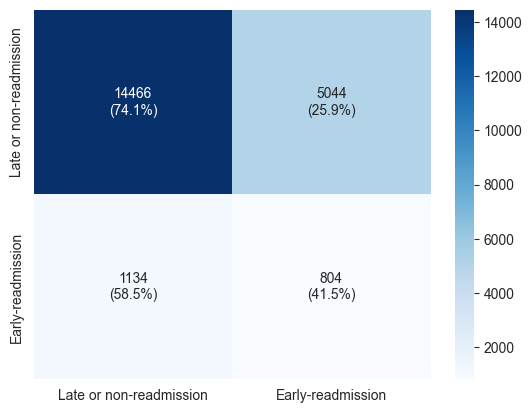

In [57]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [58]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-10, 1e-1, log=True)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        GaussianNB(**params)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [59]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

c:\Users\alero\.vscode\unibs_mldm_diabetes\.venv\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-16 07:50:44,191] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [60]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-16 07:52:32,360] Trial 0 finished with value: 0.5108961568392116 and parameters: {'var_smoothing': 0.023595832594861265}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.50840366 0.51390605 0.51673097 0.51120048 0.50423962]
Average score: 0.5108961568392116


[I 2025-01-16 07:52:34,944] Trial 3 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 7.709820935060854e-07}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:52:36,388] Trial 4 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.784017858357874e-10}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:52:37,414] Trial 2 finished with value: 0.5091738977413066 and parameters: {'var_smoothing': 0.0012049496392172365}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.50658129 0.51318091 0.51361183 0.50926506 0.5032304 ]
Average score: 0.5091738977413066


[I 2025-01-16 07:52:40,878] Trial 1 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 2.124356582042483e-07}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:52:41,900] Trial 7 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 4.0492730982532174e-07}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:52:43,544] Trial 5 finished with value: 0.5092320835288019 and parameters: {'var_smoothing': 0.0004967140092498771}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.50645323 0.51280179 0.51435387 0.50907242 0.50347912]
Average score: 0.5092320835288019


[I 2025-01-16 07:52:44,994] Trial 6 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 6.341771161901394e-09}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:13,579] Trial 8 finished with value: 0.5091546061468508 and parameters: {'var_smoothing': 6.69689443823746e-05}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.50645323 0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.5091546061468508


[I 2025-01-16 07:54:14,600] Trial 9 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 4.111954390384129e-07}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:15,608] Trial 10 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 8.124330148903864e-06}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:16,633] Trial 11 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.3973249247318641e-05}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:23,561] Trial 12 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 3.3442609537225633e-10}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:27,081] Trial 13 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 5.2166113347521364e-06}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:28,647] Trial 15 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.7702131371104203e-09}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:54:28,953] Trial 14 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 6.599138488127159e-06}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:56:04,057] Trial 16 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.1602634019765901e-08}. Best is trial 0 with value: 0.5108961568392116.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:56:05,302] Trial 17 finished with value: 0.5132639069124791 and parameters: {'var_smoothing': 0.07783740874516532}. Best is trial 17 with value: 0.5132639069124791.


Cross validation scores: [0.51147406 0.51547085 0.51842895 0.51379378 0.50715188]
Average score: 0.5132639069124791


[I 2025-01-16 07:56:07,461] Trial 19 finished with value: 0.5093050746759835 and parameters: {'var_smoothing': 0.0021703335147997813}. Best is trial 17 with value: 0.5132639069124791.


Cross validation scores: [0.50709389 0.51324572 0.5134292  0.50989797 0.5028586 ]
Average score: 0.5093050746759835


[I 2025-01-16 07:56:08,489] Trial 18 finished with value: 0.5136101694014421 and parameters: {'var_smoothing': 0.0955653034030612}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.51251641 0.51528808 0.51888422 0.51357947 0.50778267]
Average score: 0.5136101694014421


[I 2025-01-16 07:56:11,545] Trial 20 finished with value: 0.5092277810271599 and parameters: {'var_smoothing': 0.0018915583870678999}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.5069016  0.51324572 0.51329934 0.50983365 0.5028586 ]
Average score: 0.5092277810271599


[I 2025-01-16 07:56:14,987] Trial 21 finished with value: 0.5092194597980662 and parameters: {'var_smoothing': 0.00011874555749034987}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50645323 0.51280179 0.51435387 0.50907242 0.503416  ]
Average score: 0.5092194597980662


[I 2025-01-16 07:56:16,717] Trial 22 finished with value: 0.5100339598097221 and parameters: {'var_smoothing': 0.012386598866796359}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50825983 0.51379965 0.5154043  0.51028007 0.50242594]
Average score: 0.5100339598097221


[I 2025-01-16 07:56:20,023] Trial 23 finished with value: 0.5092066554142465 and parameters: {'var_smoothing': 0.000300425108749551}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.5063892  0.51280179 0.51435387 0.50907242 0.503416  ]
Average score: 0.5092066554142465


[I 2025-01-16 07:57:38,563] Trial 24 finished with value: 0.5102223371009491 and parameters: {'var_smoothing': 0.012142009271253014}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50819567 0.51418068 0.51558879 0.5102158  0.50293074]
Average score: 0.5102223371009491


[I 2025-01-16 07:57:40,491] Trial 25 finished with value: 0.5116951076204662 and parameters: {'var_smoothing': 0.03758630501631514}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50906109 0.51406975 0.51717662 0.51220118 0.50596689]
Average score: 0.5116951076204662


[I 2025-01-16 07:57:42,369] Trial 26 finished with value: 0.5095732205002985 and parameters: {'var_smoothing': 0.008611529382178894}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50773512 0.51358828 0.51480663 0.5095579  0.50217819]
Average score: 0.5095732205002985


[I 2025-01-16 07:57:43,170] Trial 27 finished with value: 0.5126053258617969 and parameters: {'var_smoothing': 0.07043074543398829}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.5108508  0.51483404 0.51731965 0.51270527 0.50731687]
Average score: 0.5126053258617969


[I 2025-01-16 07:57:44,758] Trial 28 finished with value: 0.5132583076385566 and parameters: {'var_smoothing': 0.0769389531019517}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.51160681 0.51560505 0.51823297 0.51340777 0.50743894]
Average score: 0.5132583076385566


[I 2025-01-16 07:57:46,699] Trial 29 finished with value: 0.509584546516898 and parameters: {'var_smoothing': 0.008182937548373955}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50773512 0.51358828 0.51474151 0.50974217 0.50211566]
Average score: 0.509584546516898


[I 2025-01-16 07:57:49,971] Trial 30 finished with value: 0.5114480567807224 and parameters: {'var_smoothing': 0.02617512919254451}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.5094937  0.51410039 0.51725423 0.51146374 0.50492823]
Average score: 0.5114480567807224


[I 2025-01-16 07:57:50,744] Trial 31 finished with value: 0.5093302142754708 and parameters: {'var_smoothing': 0.0042084918443365945}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50718488 0.51325516 0.51357099 0.50965057 0.50298948]
Average score: 0.5093302142754708


[I 2025-01-16 07:59:10,734] Trial 32 finished with value: 0.5092833809026003 and parameters: {'var_smoothing': 0.0007163107899287412}. Best is trial 18 with value: 0.5136101694014421.


Cross validation scores: [0.50658129 0.51280179 0.51435387 0.50920083 0.50347912]
Average score: 0.5092833809026003


[I 2025-01-16 07:59:12,965] Trial 36 finished with value: 0.5093663981247492 and parameters: {'var_smoothing': 0.0026039660848505637}. Best is trial 33 with value: 0.5137046328362549.
[I 2025-01-16 07:59:12,968] Trial 33 finished with value: 0.5137046328362549 and parameters: {'var_smoothing': 0.09988962334066634}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50696569 0.51331054 0.51336427 0.51008089 0.50311061]
Average score: 0.5093663981247492
Cross validation scores: [0.51295647 0.5151967  0.51808809 0.51408315 0.50819876]
Average score: 0.5137046328362549


[I 2025-01-16 07:59:14,295] Trial 37 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.0169339242239408e-07}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 07:59:15,705] Trial 34 finished with value: 0.5114524483446978 and parameters: {'var_smoothing': 0.02735787230075446}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50950176 0.51429481 0.51725423 0.51115724 0.50505419]
Average score: 0.5114524483446978


[I 2025-01-16 07:59:16,934] Trial 35 finished with value: 0.5091546061468508 and parameters: {'var_smoothing': 6.429181774590206e-05}. Best is trial 33 with value: 0.5137046328362549.
[I 2025-01-16 07:59:16,936] Trial 38 finished with value: 0.512592374381157 and parameters: {'var_smoothing': 0.07119143413415545}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50645323 0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.5091546061468508
Cross validation scores: [0.51033269 0.51483404 0.51803393 0.51244434 0.50731687]
Average score: 0.512592374381157


[I 2025-01-16 07:59:18,365] Trial 39 finished with value: 0.5133318818412131 and parameters: {'var_smoothing': 0.08805503828403094}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51241072 0.51538271 0.51829908 0.51284468 0.50772222]
Average score: 0.5133318818412131


[I 2025-01-16 08:00:47,010] Trial 43 finished with value: 0.5133635839244816 and parameters: {'var_smoothing': 0.07977387585589994}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51140495 0.51540096 0.51875581 0.51385324 0.50740297]
Average score: 0.5133635839244816


[I 2025-01-16 08:00:51,478] Trial 46 finished with value: 0.5092066554142465 and parameters: {'var_smoothing': 0.0002936216649840309}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51280179 0.51435387 0.50907242 0.503416  ]
Average score: 0.5092066554142465


[I 2025-01-16 08:00:52,954] Trial 40 finished with value: 0.5113807119636582 and parameters: {'var_smoothing': 0.03227245769493787}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50853406 0.51462963 0.51728244 0.51142264 0.50503479]
Average score: 0.5113807119636582


[I 2025-01-16 08:00:53,336] Trial 41 finished with value: 0.5092558092086479 and parameters: {'var_smoothing': 0.004782962943406948}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50718488 0.51325516 0.51363594 0.50965057 0.5025525 ]
Average score: 0.5092558092086479


[I 2025-01-16 08:00:54,704] Trial 47 finished with value: 0.5103792041167057 and parameters: {'var_smoothing': 0.015818910689007214}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50848484 0.51375735 0.51586091 0.51055104 0.50324187]
Average score: 0.5103792041167057


[I 2025-01-16 08:00:55,929] Trial 44 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.5971167818295732e-06}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 08:00:57,242] Trial 42 finished with value: 0.5094595166132324 and parameters: {'var_smoothing': 0.0066146333629989625}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5072744  0.51332902 0.514351   0.50978861 0.50255456]
Average score: 0.5094595166132324


[I 2025-01-16 08:01:01,240] Trial 45 finished with value: 0.5092066554142465 and parameters: {'var_smoothing': 0.0003397884765707336}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51280179 0.51435387 0.50907242 0.503416  ]
Average score: 0.5092066554142465
Cross validation scores: [0.51111643 0.51432507 0.51796392 0.5127182  0.5078445 ]
Average score: 0.5127936217390566


[I 2025-01-16 08:02:21,853] Trial 48 finished with value: 0.5127936217390566 and parameters: {'var_smoothing': 0.06495952909202085}. Best is trial 33 with value: 0.5137046328362549.
[I 2025-01-16 08:02:26,190] Trial 49 finished with value: 0.5132664707693193 and parameters: {'var_smoothing': 0.07767132357996619}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51141009 0.51547085 0.51836361 0.51372942 0.50735837]
Average score: 0.5132664707693193


[I 2025-01-16 08:02:28,756] Trial 51 finished with value: 0.5091477175692014 and parameters: {'var_smoothing': 0.0010397830318918887}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50664534 0.51305132 0.51361183 0.50913662 0.50329348]
Average score: 0.5091477175692014


[I 2025-01-16 08:02:29,625] Trial 52 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 2.0172988198086578e-05}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 08:02:36,574] Trial 50 finished with value: 0.5106107898330754 and parameters: {'var_smoothing': 0.020792356091561107}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50790001 0.51383528 0.51626334 0.51100121 0.50405412]
Average score: 0.5106107898330754


[I 2025-01-16 08:02:39,424] Trial 53 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.0466353528665461e-07}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 08:02:40,857] Trial 54 finished with value: 0.5136920830714368 and parameters: {'var_smoothing': 0.09977103694639533}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51295647 0.5151967  0.51808809 0.51408315 0.50813601]
Average score: 0.5136920830714368


[I 2025-01-16 08:02:42,875] Trial 55 finished with value: 0.5095075142707529 and parameters: {'var_smoothing': 0.0029550480457942695}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50728624 0.5134402  0.5134292  0.51014526 0.50323667]
Average score: 0.5095075142707529


[I 2025-01-16 08:03:59,330] Trial 56 finished with value: 0.5113578271985939 and parameters: {'var_smoothing': 0.03412721531422248}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50860671 0.5143835  0.51760963 0.51136188 0.50482741]
Average score: 0.5113578271985939


[I 2025-01-16 08:04:02,312] Trial 57 finished with value: 0.5102363647911139 and parameters: {'var_smoothing': 0.014695566440890366}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50821782 0.51369257 0.51586091 0.51022976 0.50318076]
Average score: 0.5102363647911139


[I 2025-01-16 08:04:05,359] Trial 58 finished with value: 0.5119113078582687 and parameters: {'var_smoothing': 0.03931344181994911}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50906657 0.51419913 0.51756105 0.51226557 0.50646422]
Average score: 0.5119113078582687


[I 2025-01-16 08:04:06,315] Trial 59 finished with value: 0.5136782452077624 and parameters: {'var_smoothing': 0.09261476286140205}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51272403 0.51523171 0.5184924  0.51392765 0.50801543]
Average score: 0.5136782452077624


[I 2025-01-16 08:04:13,196] Trial 60 finished with value: 0.5120150375275098 and parameters: {'var_smoothing': 0.04434176828979675}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50939118 0.51491377 0.51802712 0.51233645 0.50540666]
Average score: 0.5120150375275098


[I 2025-01-16 08:04:16,408] Trial 61 finished with value: 0.5092249815660566 and parameters: {'var_smoothing': 0.0014021500674208844}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50677346 0.51318091 0.51367681 0.50951216 0.50298157]
Average score: 0.5092249815660566


[I 2025-01-16 08:04:18,687] Trial 62 finished with value: 0.5136710340263783 and parameters: {'var_smoothing': 0.09396815070925978}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51258836 0.5151591  0.51875357 0.51352471 0.50832943]
Average score: 0.5136710340263783


[I 2025-01-16 08:04:20,794] Trial 63 finished with value: 0.5096535777162386 and parameters: {'var_smoothing': 0.00750872199063993}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50772304 0.51352345 0.51454621 0.5100458  0.50242938]
Average score: 0.5096535777162386


[I 2025-01-16 08:05:32,693] Trial 64 finished with value: 0.5104948928641877 and parameters: {'var_smoothing': 0.016793230394523195}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50836673 0.51395175 0.51611099 0.51067961 0.50336538]
Average score: 0.5104948928641877


[I 2025-01-16 08:05:36,970] Trial 65 finished with value: 0.5092913848839224 and parameters: {'var_smoothing': 0.004148617061228237}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50718488 0.51325516 0.51344112 0.5095863  0.50298948]
Average score: 0.5092913848839224


[I 2025-01-16 08:05:38,727] Trial 66 finished with value: 0.5119914227019542 and parameters: {'var_smoothing': 0.04140995894364799}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50868908 0.51458749 0.51795381 0.51175763 0.5069691 ]
Average score: 0.5119914227019542


[I 2025-01-16 08:05:40,655] Trial 67 finished with value: 0.5100579794394002 and parameters: {'var_smoothing': 0.013767818219077793}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50777983 0.51343354 0.51579565 0.51041575 0.50286512]
Average score: 0.5100579794394002


[I 2025-01-16 08:05:53,217] Trial 68 finished with value: 0.5136877304751215 and parameters: {'var_smoothing': 0.09794692200838016}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51257211 0.51561073 0.51842042 0.51376211 0.50807327]
Average score: 0.5136877304751215


[I 2025-01-16 08:05:54,926] Trial 70 finished with value: 0.5105853749673951 and parameters: {'var_smoothing': 0.020604948343784624}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50770816 0.51390005 0.51626334 0.51100121 0.50405412]
Average score: 0.5105853749673951


[I 2025-01-16 08:06:01,321] Trial 69 finished with value: 0.5120163253241616 and parameters: {'var_smoothing': 0.05225339704944258}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50952019 0.51407934 0.51884653 0.51156844 0.50606712]
Average score: 0.5120163253241616


[I 2025-01-16 08:06:03,286] Trial 71 finished with value: 0.5136230031613397 and parameters: {'var_smoothing': 0.09588172625692166}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51251641 0.51528808 0.51888422 0.51364363 0.50778267]
Average score: 0.5136230031613397


[I 2025-01-16 08:07:06,601] Trial 72 finished with value: 0.5136373475661593 and parameters: {'var_smoothing': 0.09726576971787164}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51257211 0.51535259 0.51855355 0.51369794 0.50801054]
Average score: 0.5136373475661593


[I 2025-01-16 08:07:13,314] Trial 73 finished with value: 0.5095437519154119 and parameters: {'var_smoothing': 0.007771742672979956}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50760692 0.51345863 0.5146113  0.50992625 0.50211566]
Average score: 0.5095437519154119


[I 2025-01-16 08:07:15,139] Trial 75 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 8.899545375742853e-09}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 08:07:16,972] Trial 74 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 6.124417796908636e-10}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 08:07:32,452] Trial 76 finished with value: 0.5110238648456972 and parameters: {'var_smoothing': 0.024014711469017194}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50897188 0.51390605 0.51667548 0.51120048 0.50436544]
Average score: 0.5110238648456972


[I 2025-01-16 08:07:35,233] Trial 77 finished with value: 0.5118623024469966 and parameters: {'var_smoothing': 0.05018171000859279}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50932873 0.51382116 0.51876896 0.5114405  0.50595216]
Average score: 0.5118623024469966


[I 2025-01-16 08:07:40,086] Trial 78 finished with value: 0.5135755842013288 and parameters: {'var_smoothing': 0.09230231510354624}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51265994 0.51523171 0.51842714 0.51360647 0.50795266]
Average score: 0.5135755842013288


[I 2025-01-16 08:07:41,013] Trial 79 finished with value: 0.5113548286709089 and parameters: {'var_smoothing': 0.028899986254985847}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5093885  0.51391167 0.51745061 0.51078015 0.50524321]
Average score: 0.5113548286709089


[I 2025-01-16 08:08:50,279] Trial 80 finished with value: 0.5096281161842802 and parameters: {'var_smoothing': 0.009674008824003906}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50818406 0.51315178 0.51500204 0.50975055 0.50205216]
Average score: 0.5096281161842802


[I 2025-01-16 08:08:57,844] Trial 81 finished with value: 0.5118745777630552 and parameters: {'var_smoothing': 0.049821023861071005}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50932873 0.51401493 0.51863784 0.51137636 0.50601502]
Average score: 0.5118745777630552


[I 2025-01-16 08:08:59,882] Trial 83 finished with value: 0.5134221916509084 and parameters: {'var_smoothing': 0.0918793863087186}. Best is trial 33 with value: 0.5137046328362549.
[I 2025-01-16 08:08:59,977] Trial 82 finished with value: 0.5134715860336999 and parameters: {'var_smoothing': 0.08892432295360517}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51246773 0.51516721 0.51836189 0.51334971 0.50776442]
Average score: 0.5134221916509084
Cross validation scores: [0.51247478 0.51531125 0.51862553 0.5129729  0.50797347]
Average score: 0.5134715860336999


[I 2025-01-16 08:09:15,330] Trial 84 finished with value: 0.5092683850219158 and parameters: {'var_smoothing': 0.004808764336738626}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50718488 0.51325516 0.51363594 0.50965057 0.50261538]
Average score: 0.5092683850219158


[I 2025-01-16 08:09:17,031] Trial 85 finished with value: 0.5108705205640985 and parameters: {'var_smoothing': 0.023500717449842935}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50833962 0.51377653 0.51679635 0.51120048 0.50423962]
Average score: 0.5108705205640985


[I 2025-01-16 08:09:22,572] Trial 86 finished with value: 0.5098229887267961 and parameters: {'var_smoothing': 0.011004049480833555}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50793914 0.51391256 0.51513236 0.50976619 0.50236469]
Average score: 0.5098229887267961


[I 2025-01-16 08:09:23,595] Trial 87 finished with value: 0.5118750967886919 and parameters: {'var_smoothing': 0.047412913549951204}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50920134 0.51433622 0.51837573 0.5117614  0.5057008 ]
Average score: 0.5118750967886919


[I 2025-01-16 08:10:34,956] Trial 88 finished with value: 0.511313786527033 and parameters: {'var_smoothing': 0.03141874158072174}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50890753 0.51449995 0.5172734  0.51110487 0.50478318]
Average score: 0.511313786527033


[I 2025-01-16 08:10:45,664] Trial 89 finished with value: 0.5121622395724159 and parameters: {'var_smoothing': 0.05659233888308991}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5097099  0.51401197 0.51801931 0.51214529 0.50692473]
Average score: 0.5121622395724159


[I 2025-01-16 08:10:46,607] Trial 90 finished with value: 0.5136941168884922 and parameters: {'var_smoothing': 0.0994810306684397}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51282831 0.51533503 0.51808809 0.51408315 0.50813601]
Average score: 0.5136941168884922


[I 2025-01-16 08:10:46,987] Trial 91 finished with value: 0.5104489674686965 and parameters: {'var_smoothing': 0.017864279349392786}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50787359 0.5138289  0.51630698 0.51087254 0.50336283]
Average score: 0.5104489674686965


[I 2025-01-16 08:11:01,909] Trial 92 finished with value: 0.5123586655391092 and parameters: {'var_smoothing': 0.05415622755897962}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50958334 0.51433708 0.51897767 0.51221044 0.5066848 ]
Average score: 0.5123586655391092


[I 2025-01-16 08:11:03,011] Trial 93 finished with value: 0.509141801763031 and parameters: {'var_smoothing': 1.1518963343025874e-10}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.5063892  0.51273706 0.51415853 0.50900822 0.503416  ]
Average score: 0.509141801763031


[I 2025-01-16 08:11:08,416] Trial 94 finished with value: 0.51363066045642 and parameters: {'var_smoothing': 0.09431986430316755}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51265242 0.5151591  0.51875357 0.51325878 0.50832943]
Average score: 0.51363066045642


[I 2025-01-16 08:11:10,228] Trial 95 finished with value: 0.5114395916473973 and parameters: {'var_smoothing': 0.027298953741261615}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50950176 0.51429481 0.51725423 0.51109296 0.50505419]
Average score: 0.5114395916473973


[I 2025-01-16 08:11:46,957] Trial 96 finished with value: 0.5100469277801188 and parameters: {'var_smoothing': 0.012360156083374865}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50825983 0.51386449 0.5154043  0.51028007 0.50242594]
Average score: 0.5100469277801188


[I 2025-01-16 08:11:52,029] Trial 97 finished with value: 0.5136815163746256 and parameters: {'var_smoothing': 0.09672856592392604}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51231609 0.51535259 0.51908028 0.5138362  0.50782242]
Average score: 0.5136815163746256


[I 2025-01-16 08:11:52,727] Trial 98 finished with value: 0.5122186241050122 and parameters: {'var_smoothing': 0.053354213726916865}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.50964787 0.51433769 0.5187209  0.51195352 0.50643314]
Average score: 0.5122186241050122


[I 2025-01-16 08:11:53,004] Trial 99 finished with value: 0.513610432898702 and parameters: {'var_smoothing': 0.09282012111723616}. Best is trial 33 with value: 0.5137046328362549.


Cross validation scores: [0.51272403 0.51503016 0.51855768 0.51366209 0.50807821]
Average score: 0.513610432898702


In [61]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 33
Best Parameters: {'var_smoothing': 0.09988962334066634}
Best Value: 0.5137046328362549


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [62]:
optuna.visualization.plot_optimization_history(study)

In [63]:
optuna.visualization.plot_slice(study)

In [64]:
optuna.visualization.plot_param_importances(study)

In [65]:
optuna.visualization.plot_parallel_coordinate(study)

In [66]:
optuna.visualization.plot_contour(study)

In [67]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [68]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    GaussianNB(**best_params)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('gaussiannb', GaussianNB(var_smoothing=0.09988962334066634))])

In [69]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [70]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.7082625636926766
Test accuracy:  0.7072454308093995


In [71]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.74      0.82     19510
      Early-readmission       0.14      0.42      0.21      1938

               accuracy                           0.71     21448
              macro avg       0.53      0.58      0.51     21448
           weighted avg       0.86      0.71      0.77     21448



In [72]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

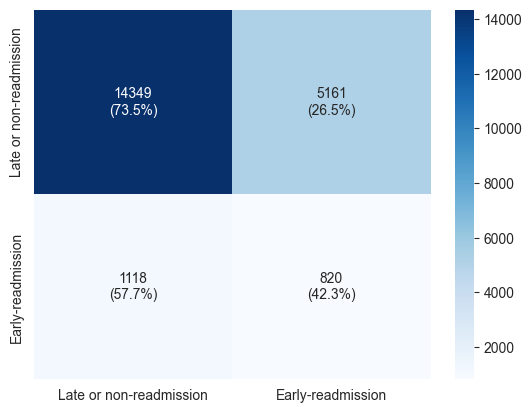

In [73]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

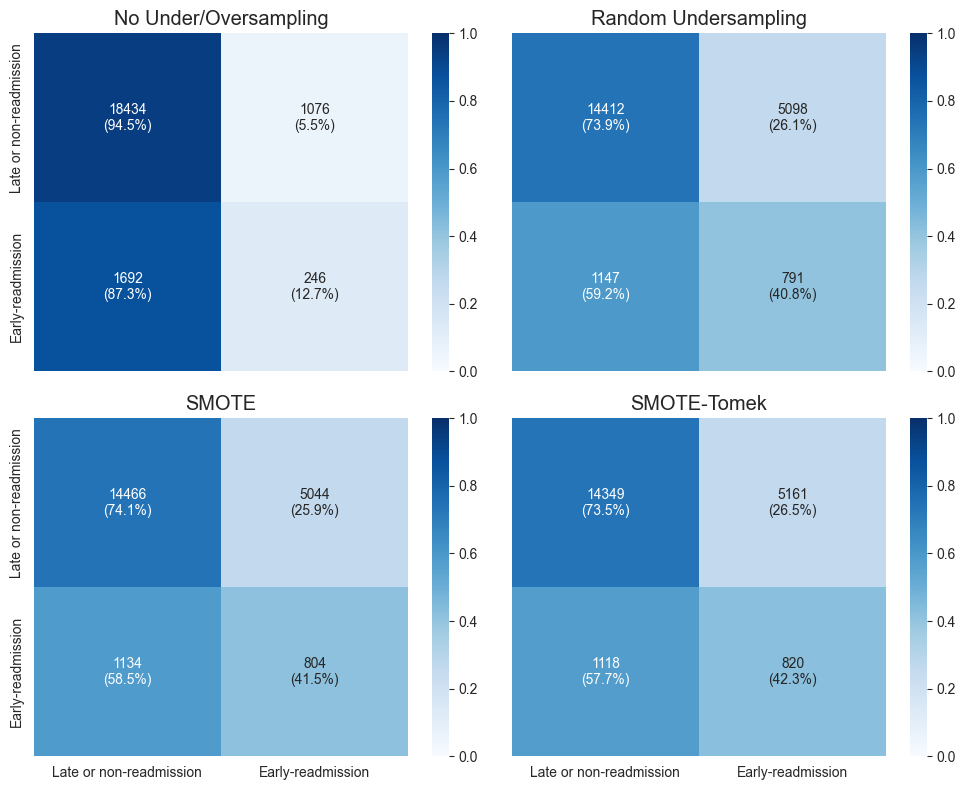

In [74]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [75]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.535892,0.551006,0.540542,0.535892,0.870944
Random Undersampling,0.573425,0.530299,0.512022,0.573425,0.708831
SMOTE,0.578163,0.532395,0.515282,0.578163,0.711954
SMOTE-Tomek,0.579293,0.532409,0.513789,0.579293,0.707245


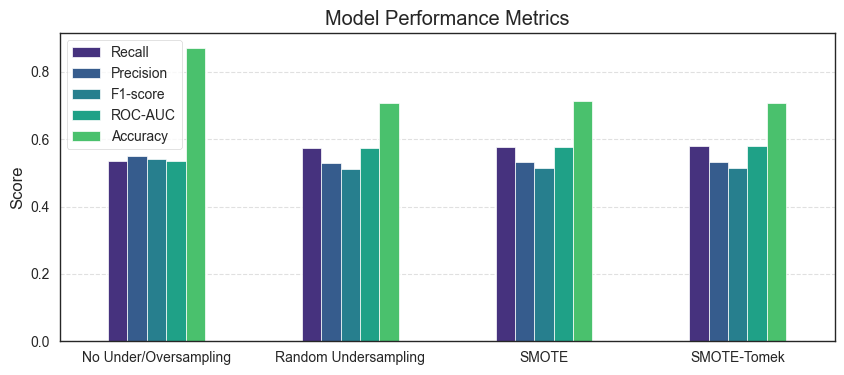

In [76]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()